# Ranking annotations from METASPACE datasets

In this workflow we will first download METASPACE data using the [python client](https://metaspace2020.readthedocs.io/en/latest/) and
the [metaspace-converter](https://metaspace2020.github.io/metaspace-converter/index.html) package,
and then use the package to rank the lipid candidate annotations using lipid metabolic networks.

First, the required packages are imported

In [23]:
import metaspace
import metaspace_converter
import linex2metaspace as lx2m

import networkx as nx
import matplotlib.pyplot as plt

We will perform the exemplary analysis on a high quality METASPACE dataset with a high number of annotations: [2016-09-21_16h06m56s](https://metaspace2020.eu/annotations?db_id=6&ds=2016-09-21_16h06m56s).

In [3]:
dataset_id = '2016-09-21_16h06m56s'
database = ('HMDB', 'v4')
fdr_cutoff = .1

## Download through the python client

We can download the annotation table through the python client package:

In [4]:
sm = metaspace.SMInstance()
ds = sm.dataset(id=dataset_id)

# Downloading the annotations
annotations = ds.results(database=database, fdr=fdr_cutoff)

The resulting table contains the the required information to perform the network-based lipid ranking: 
* Ion information (`formula` & `adduct`)
* Names of lipid candidates that are parsed and then used for the ranking (`moleculeNames`)

In [7]:
annotations

ionFormula             ion          mz       msm  \
formula     adduct                                                       
C44H86NO8P  +H        C44H87NO8P   C44H86NO8P+H+  788.616362  0.975502   
C40H80NO8P  +H        C40H81NO8P   C40H80NO8P+H+  734.569412  0.952178   
C41H83N2O6P +K      C41H83N2O6PK  C41H83N2O6P+K+  769.562014  0.947626   
            +H       C41H84N2O6P  C41H83N2O6P+H+  731.606132  0.946311   
C26H42O4    +H          C26H43O4     C26H42O4+H+  419.315567  0.937039   
...                          ...             ...         ...       ...   
C55H96O6    +H          C55H97O6     C55H96O6+H+  853.727948  0.522666   
C24H26O6    +H          C24H27O6     C24H26O6+H+  411.180195  0.517545   
C46H88NO10P +H       C46H89NO10P  C46H88NO10P+H+  846.621841  0.517033   
C49H78O4    +H          C49H79O4     C49H78O4+H+  731.597268  0.515719   
C43H86NO8P  +H        C43H87NO8P   C43H86NO8P+H+  776.616362  0.515395   

                    rhoSpatial  rhoSpectral       moc   fdr  offSample  \
formula     adduct                                                       
C44H86NO8P  +H        0.985168     0.991898  0.998277  0.05      False   
C40H80NO8P  +H        0.958258     0.994579  0.999071  0.05      False   
C41H83N2O6P +K        0.959462     0.988501  0.999153  0.05      False   
            +H        0.964511     0.982116  0.998996  0.05      False   
C26H42O4    +H        0.960247     0.976837  0.998970  0.05      False   
...                        ...          ...       ...   ...        ...   
C55H96O6    +H        0.574491     0.931053  0.977160  0.10      False   
C24H26O6    +H        0.543960     0.957293  0.993886  0.10      False   
C46H88NO10P +H        0.638335     0.812527  0.996856  0.10      False   
C49H78O4    +H        0.596372     0.866240  0.998291  0.10      False   
C43H86NO8P  +H        0.553365     0.933625  0.997598  0.10      False   

                                                        isotopeImages  \
formula     adduct                                                      
C44H86NO8P  +H      [{'mz': 788.6163620428745, 'url': 'https://s3....   
C40H80NO8P  +H      [{'mz': 734.5694118508743, 'url': 'https://s3....   
C41H83N2O6P +K      [{'mz': 769.5620135848744, 'url': 'https://s3....   
            +H      [{'mz': 731.6061317168744, 'url': 'https://s3....   
C26H42O4    +H      [{'mz': 419.3155666548801, 'url': 'https://s3....   
...                                                               ...   
C55H96O6    +H      [{'mz': 853.7279476228744, 'url': 'https://s3....   
C24H26O6    +H      [{'mz': 411.18019538288013, 'url': 'https://s3...   
C46H88NO10P +H      [{'mz': 846.6218413468742, 'url': 'https://s3....   
C49H78O4    +H      [{'mz': 731.5972678068741, 'url': 'https://s3....   
C43H86NO8P  +H      [{'mz': 776.6163620428745, 'url': 'https://s3....   

                   colocCoeff  \
formula     adduct              
C44H86NO8P  +H           None   
C40H80NO8P  +H           None   
C41H83N2O6P +K           None   
            +H           None   
C26H42O4    +H           None   
...                       ...   
C55H96O6    +H           None   
C24H26O6    +H           None   
C46H88NO10P +H           None   
C49H78O4    +H           None   
C43H86NO8P  +H           None   

                                                        moleculeNames  \
formula     adduct                                                      
C44H86NO8P  +H      [PC(14:0/22:1(13Z)), PC(14:1(9Z)/22:0), PC(16:...   
C40H80NO8P  +H      [PC(16:0/16:0), PC(14:0/18:0), PC(18:0/14:0), ...   
C41H83N2O6P +K      [SM(d18:0/18:1(11Z)), SM(d18:0/18:1(9Z)), stea...   
            +H      [SM(d18:0/18:1(11Z)), SM(d18:0/18:1(9Z)), stea...   
C26H42O4    +H      [11'-Carboxy-alpha-chromanol, Hexadecyl ferulate]   
...                                                               ...   
C55H96O6    +H      [TG(16:0/16:1(9Z)/20:4(5Z,8Z,11Z,14Z)), TG(16:...   
C24H26O6    +H      [1-Isomangostin, Dulxanthone B, alpha-M

## Download through the `metaspace-converter` package

Another way to download METASPACE datasets (directly into `AnnData` that contain all information, includin ion images) is the [metaspace-converter](https://metaspace2020.github.io/metaspace-converter/index.html).
This data can also be used to rank lipid annotations.

In [9]:
adata = metaspace_converter.metaspace_to_anndata(dataset_id=dataset_id, database=database, fdr=fdr_cutoff)
adata

100%|████████████████████████████████████████| 202/202 [00:01<00:00, 157.96it/s]


AnnData object with n_obs × n_vars = 13365 × 202
    obs: 'ion_image_pixel_x', 'ion_image_pixel_y', 'ion_image_shape_y', 'ion_image_shape_x'
    var: 'formula', 'adduct', 'ionFormula', 'ion', 'mz', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc', 'fdr', 'offSample', 'isotopeImages', 'colocCoeff', 'moleculeNames', 'moleculeIds', 'intensity'
    uns: 'metaspace'
    obsm: 'spatial'

The `adata.var` table contains the same information as the output of the previously downloaded annotations table (just using a different indexing):

In [11]:
adata.var

,formula,adduct,ionFormula,ion,mz,msm,rhoSpatial,rhoSpectral,moc,fdr,offSample,isotopeImages,colocCoeff,moleculeNames,moleculeIds,intensity
formula_adduct,,,,,,,,,,,,,,,,
C44H86NO8P+H,C44H86NO8P,+H,C44H87NO8P,C44H86NO8P+H+,788.616362,0.975502,0.985168,0.991898,0.998277,0.05,False,"[{""mz"": 788.6163620428745, ""url"": ""https://s3....",NaN,"[""PC(14:0/22:1(13Z))"", ""PC(14:1(9Z)/22:0)"", ""P...","[""HMDB0007887"", ""HMDB0007919"", ""HMDB0007978"", ...",8.213491e+06
C40H80NO8P+H,C40H80NO8P,+H,C40H81NO8P,C40H80NO8P+H+,734.569412,0.952178,0.958258,0.994579,0.999071,0.05,False,"[{""mz"": 734.5694118508743, ""url"": ""https://s3....",NaN,"[""PC(16:0/16:0)"", ""PC(14:0/18:0)"", ""PC(18:0/14...","[""HMDB0000564"", ""HMDB0007871"", ""HMDB0008031"", ...",1.067504e+07
C41H83N2O6P+K,C41H83N2O6P,+K,C41H83N2O6PK,C41H83N2O6P+K+,769.562014,0.947626,0.959462,0.988501,0.999153,0.05,False,"[{""mz"": 769.5620135848744, ""url"": ""https://s3....",NaN,"[""SM(d18:0/18:1(11Z))"", ""SM(d18:0/18:1(9Z))"", ...","[""HMDB0012088"", ""HMDB0012089"", ""HMDB0062559""]",7.441223e+06
C41H83N2O6P+H,C41H83N2O6P,+H,C41H84N2O6P,C41H83N2O6P+H+,731.606132,0.946311,0.964511,0.982116,0.998996,0.05,False,"[{""mz"": 731.6061317168744, ""url"": ""https://s3....",NaN,"[""SM(d18:0/18:1(11Z))"", ""SM(d18:0/18:1(9Z))"", ...","[""HMDB0012088"", ""HMDB0012089"", ""HMDB0062559""]",2.758408e+06
C26H42O4+H,C26H42O4,+H,C26H43O4,C26H42O4+H+,419.315567,0.937039,0.960247,0.976837,0.998970,0.05,False,"[{""mz"": 419.3155666548801, ""url"": ""https://s3....",NaN,"[""11'-Carboxy-alpha-chromanol"", ""Hexadecyl fer...","[""HMDB0012515"", ""HMDB0039317""]",1.019578e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C55H96O6+H,C55H96O6,+H,C55H97O6,C55H96O6+H+,853.727948,0.522666,0.574491,0.931053,0.977160,0.10,False,"[{""mz"": 853.7279476228744, ""url"": ""https://s3....",NaN,"[""TG(16:0/16:1(9Z)/20:4(5Z,8Z,11Z,14Z))"", ""TG(...","[""HMDB0005380"", ""HMDB0005446"", ""HMDB0010450"", ...",1.517550e+05
C24H26O6+H,C24H26O6,+H,C24H27O6,C24H26O6+H+,411.180195,0.517545,0.543960,0.957293,0.993886,0.10,False,"[{""mz"": 411.18019538288013, ""url"": ""https://s3...",NaN,"[""1-Isomangostin"", ""Dulxanthone B"", ""alpha-Man...","[""HMDB0029981"", ""HMDB0032729"", ""HMDB0035796"", ...",2.976548e+04
C46H88NO10P+H,C46H88NO10P,+H,C46H89NO10P,C46H88NO10P+H+,846.621841,0.517033,0.638335,0.812527,0.996856,0.10,False,"[{""mz"": 846.6218413468742, ""url"": ""https://s3....",NaN,"[""PS(16:0/24:1(15Z))"", ""PS(16:1(9Z)/24:0)"", ""P...","[""HMDB0112356"", ""HMDB0112370"", ""HMDB0112380"", ...",5.447059e+04


## Lipid ranking

We can now use this data to perform the lipid ranking algorithm.

We first need to load some information about lipid classes and reactions before we can create the networks:

In [12]:
ref_dict = lx2m.get_lx2_ref_lip_dict()
class_reactions = lx2m.get_organism_combined_class_reactions(ref_dict)

Next, we can perform the ranking. The whole pipeline can be run through one function:

In [13]:
(new_annotations, lipid_graph, annotation_graph) = lx2m.make_lipid_networks(
    ann=annotations, class_reacs=class_reactions,
    lipid_col='moleculeNames', bootstraps=30, verbose=False)

1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


The updated annotations table as a new column `parsed_lipids`, which contains all the lipid candidates per annotation which could be parsed (and therefore used for ranking) by the package:

In [20]:
new_annotations

ionFormula              ion          mz       msm  \
formula     adduct                                                         
C44H86NO8P  +H         C44H87NO8P    C44H86NO8P+H+  788.616362  0.975502   
C40H80NO8P  +H         C40H81NO8P    C40H80NO8P+H+  734.569412  0.952178   
C41H83N2O6P +K       C41H83N2O6PK   C41H83N2O6P+K+  769.562014  0.947626   
            +H        C41H84N2O6P   C41H83N2O6P+H+  731.606132  0.946311   
            +Na     C41H83N2O6PNa  C41H83N2O6P+Na+  753.588076  0.923331   
...                           ...              ...         ...       ...   
C55H98O6    +H           C55H99O6      C55H98O6+H+  855.743598  0.524775   
C48H80NO8P  +H         C48H81NO8P    C48H80NO8P+H+  830.569412  0.524175   
C55H96O6    +H           C55H97O6      C55H96O6+H+  853.727948  0.522666   
C46H88NO10P +H        C46H89NO10P   C46H88NO10P+H+  846.621841  0.517033   
C43H86NO8P  +H         C43H87NO8P    C43H86NO8P+H+  776.616362  0.515395   

                    rhoSpatial  rhoSpectral       moc   fdr  offSample  \
formula     adduct                                                       
C44H86NO8P  +H        0.985168     0.991898  0.998277  0.05      False   
C40H80NO8P  +H        0.958258     0.994579  0.999071  0.05      False   
C41H83N2O6P +K        0.959462     0.988501  0.999153  0.05      False   
            +H        0.964511     0.982116  0.998996  0.05      False   
            +Na       0.937898     0.985354  0.999100  0.05      False   
...                        ...          ...       ...   ...        ...   
C55H98O6    +H        0.612818     0.864342  0.990732  0.10       True   
C48H80NO8P  +H        0.555962     0.944001  0.998754  0.10      False   
C55H96O6    +H        0.574491     0.931053  0.977160  0.10      False   
C46H88NO10P +H        0.638335     0.812527  0.996856  0.10      False   
C43H86NO8P  +H        0.553365     0.933625  0.997598  0.10      False   

                                                        isotopeImages  \
formula     adduct                                                      
C44H86NO8P  +H      [{'mz': 788.6163620428745, 'url': 'https://s3....   
C40H80NO8P  +H      [{'mz': 734.5694118508743, 'url': 'https://s3....   
C41H83N2O6P +K      [{'mz': 769.5620135848744, 'url': 'https://s3....   
            +H      [{'mz': 731.6061317168744, 'url': 'https://s3....   
            +Na     [{'mz': 753.5880763448744, 'url': 'https://s3....   
...                                                               ...   
C55H98O6    +H      [{'mz': 855.7435976868743, 'url': 'https://s3....   
C48H80NO8P  +H      [{'mz': 830.5694118508743, 'url': 'https://s3....   
C55H96O6    +H      [{'mz': 853.7279476228744, 'url': 'https://s3....   
C46H88NO10P +H      [{'mz': 846.6218413468742, 'url': 'https://s3....   
C43H86NO8P  +H      [{'mz': 776.6163620428745, 'url': 'https://s3....   

                   colocCoeff  \
formula     adduct              
C44H86NO8P  +H           None   
C40H80NO8P  +H           None   
C41H83N2O6P +K           None   
            +H           None   
            +Na          None   
...                       ...   
C55H98O6    +H           None   
C48H80NO8P  +H           None   
C55H96O6    +H           None   
C46H88NO10P +H           None   
C43H86NO8P  +H           None   

                                                        moleculeNames  \
formula     adduct                                                      
C44H86NO8P  +H      [PC(14:0/22:1(13Z)), PC(14:1(9Z)/22:0), PC(16:...   
C40H80NO8P  +H      [PC(16:0/16:0), PC(14:0/18:0), PC(18:0/14:0), ...   
C41H83N2O6P +K      [SM(d18:0/18:1(11Z)), SM(d18:0/18:1(9Z)), stea...   
            +H      [SM(d18:0/18:1(11Z)), SM(d18:0/18:1(9Z)), stea...   
            +Na     [SM(d18:0/18:1(11Z)), SM(d18:0/18:1(9Z)), stea...   
...                                                               ...   
C55H98O6    +H      [TG(16:0/16:0/20:4(5Z,8Z,11Z,14Z)), TG(16:0/18...   
C48H80NO8P  +H      [PC(18:2(9Z,12

The lipid graph gives is the merged lipid network of all lipids across all the bootstraps.
It gives an overview about the overall biochemical connectivity of the data. 
The better the connectivity, the more biochemically relevant is the ranking:

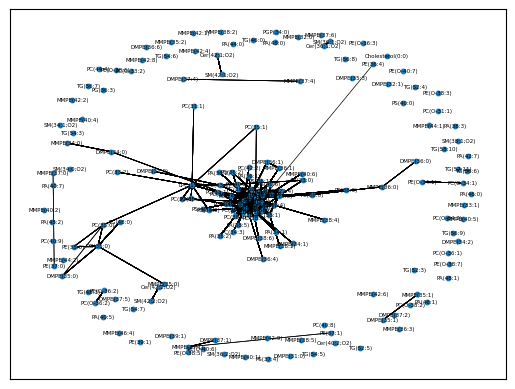

In [24]:
g = lipid_graph

pos = nx.spring_layout(g, k=.8)

nx.draw_networkx_nodes(g, pos=pos, node_size=10)
nx.draw_networkx_edges(g, pos=pos, width=.5)
nx.draw_networkx_labels(g, pos=pos, font_size=4)
plt.show()

We can also show the network which connected ions (annotations) if any of their lipid candidates had connections to other ions in any of the bootstraps.

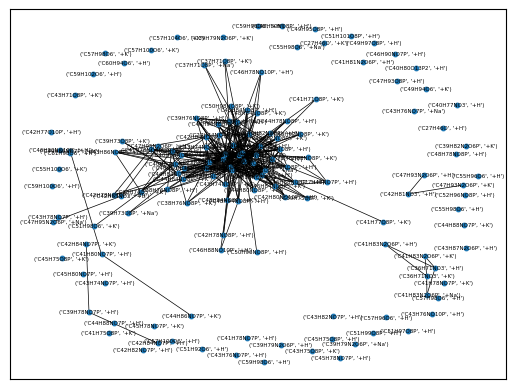

In [26]:
g = annotation_graph

pos = nx.spring_layout(g, k=.3)

nx.draw_networkx_nodes(g, pos=pos, node_size=10)
nx.draw_networkx_edges(g, pos=pos, width=.5)
nx.draw_networkx_labels(g, pos=pos, font_size=4)
plt.show()

Looking at the two networks we can see that there is a large component of annotations which show a high connectivity during the bootstraps to other annotations.
For those lipids we are able to perform a robust ranking of annotations based on their biochemical connections, whereas annotations which don't have any connections, 
the ranking cannot be performed.

This is an important information to consider when using the package. 

The information about the ranking for each annotation is saved as a node attribute in the `annotation_graph`.

In [35]:
## Example to access the ranking node attribute:
annotation_graph.nodes(data=True)[('C46H84NO8P', '+K')]

{'sum_species': PC(38:4)      6.0
 MMPE(40:4)    0.0
 dtype: float64}

In the example we can see that for the annotation `('C46H84NO8P', '+K')`, two parsed candidate annotations exist on the lipid sum formula level (saved in the node attribute `sum_species`): 
`PC(38:4)` and `MMPE(40:4)`.

`PC(38:4)` achieved on average 6 connections per bootstrap, whereas `MMPE(40:4)` did not achieve any connection.
From this we can conclude that the annotation `PC(38:4)` is the biochemically underlying lipid for the ion `('C46H84NO8P', '+K')`.

In the next step we can extract the biochemically most likely candidate lipid for each annotation from the network and add it to the annotation table.


In [48]:
ranked_annotations = lx2m.candidate_selection(new_annotations, annotation_graph, cutoff=1)

The resulting table contains 4 new columns:

* `is_ranked` stores whether a ranking could be performed for this annotation. 
  E.g. if none of the lipid candidates had any connections, ranking was not performed for this lipid.
* `utilized_sum_species` provides a list of all lipids that were used for the ranking.
* `ranked_lipids` contains all lipids with at least one connection during bootstrapping ranked in descending order.
* `candidates` contains a list of lipids as candidates molecules per annotation. The number of lipids is decided by the `cutoff` parameter (number of lipids used as candidates.)

In [49]:
ranked_annotations[['is_ranked', 'utilized_sum_species', 'ranked_lipids', 'candidates']]

is_ranked                     utilized_sum_species  \
formula     adduct                                                       
C44H86NO8P  +H           True  PC(36:1)|MMPE(38:1)|DMPE(37:1)|PE(39:1)   
C40H80NO8P  +H           True  PC(32:0)|PE(35:0)|DMPE(33:0)|MMPE(34:0)   
C41H83N2O6P +K           True                              SM(36:1;O2)   
            +H           True                              SM(36:1;O2)   
            +Na          True                              SM(36:1;O2)   
...                       ...                                      ...   
C55H98O6    +H          False                                 TG(52:4)   
C48H80NO8P  +H          False                      MMPE(42:8)|PC(40:8)   
C55H96O6    +H          False                                 TG(52:5)   
C46H88NO10P +H           True                                 PS(40:1)   
C43H86NO8P  +H           True  PC(35:0)|MMPE(37:0)|DMPE(36:0)|PE(38:0)   

                                              ranked_lipids     candidates  
formula     adduct                                                          
C44H86NO8P  +H               PC(36:1)|MMPE(38:1)|DMPE(37:1)     [PC(36:1)]  
C40H80NO8P  +H      PC(32:0)|PE(35:0)|DMPE(33:0)|MMPE(34:0)     [PC(32:0)]  
C41H83N2O6P +K                                  SM(36:1;O2)  [SM(36:1;O2)]  
            +H                                  SM(36:1;O2)  [SM(36:1;O2)]  
            +Na                                 SM(36:1;O2)  [SM(36:1;O2)]  
...                                                     ...            ...  
C55H98O6    +H                                          NaN            NaN  
C48H80NO8P  +H                                          NaN            NaN  
C55H96O6    +H                                          NaN            NaN  
C46H88NO10P +H                                     PS(40:1)     [PS(40:1)]  
C43H86NO8P  +H      PC(35:0)|MMPE(37:0)|DMPE(36:0)|PE(38:0)     [PC(35:0)]  

[144 rows x 4 columns]